In [17]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft
import tqdm

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [18]:
# mpl.use("pgf")  # to display graphs remove this line
mpl.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
line = 0.75

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
import multiprocessing as mp
import tqdm
from functools import partial

from specsens import util
from specsens import util_sim
from specsens import WirelessMicrophone
from specsens import WhiteGaussianNoise
from specsens import Stft
from specsens import WidebandEnergyDetector
from specsens import noise_est as noise_esti


def generation(f_sample, length_sec, itrs, noise_power, signal_power,
               noise_uncert, window, fft_len, sigs, num_bands,
               band_noise_est, cov_size, seeds):

    # create new signal objects
    wm = WirelessMicrophone(f_sample=f_sample, t_sec=length_sec, seed=seeds[0])
    wgn = WhiteGaussianNoise(f_sample=f_sample,
                             t_sec=length_sec,
                             seed=seeds[1])

    # local rng
    rng = np.random.default_rng(seeds[2])

    # calculate noise power with uncertainty
    gen_noise_power = rng.normal(loc=noise_power, scale=noise_uncert)

    # list of noise estimation errors
    errs_time = np.array([])
    errs_band = np.array([])
    errs_eig_avg = np.array([])
    errs_eig_hist = np.array([])
    errs_eig_kde = np.array([])
    errs_eig_mle = np.array([])

    # 'inner' interations loop
    for _ in range(itrs):

        sig = wm.soft(f_center=0., power=signal_power, dB=True)
        for i in range(-int(sigs*100000), 0, 50000):
            sig += wm.soft(f_center=i, power=signal_power, dB=True)
        for i in range(50000, int(sigs*100000+50000), 50000):
            sig += wm.soft(f_center=i, power=signal_power, dB=True)
        
        # generate noise
        noise = wgn.signal(power=gen_noise_power, dB=True)

        # create acutal signal
        both = sig + noise

        # time noise estimation
        est_time = util.dB_power(np.mean(np.abs(noise)**2.))

        # create a Short Time Fourier Transform object
        sft = Stft(n=fft_len, window=window)
        # use the stft to transform the signal into the frequency domain
        f, psd = sft.stft(both, f_sample, normalized=False, dB=False)
#         f, psd = sft.stft(noise, f_sample, normalized=False, dB=False)
        # create a Wideband Energy Detector object
        fed = WidebandEnergyDetector(num_bands=num_bands,
                                     f_sample=f_sample,
                                     fft_len=fft_len,
                                     freqs=f)
        # compute energy for all bands
        bands = fed.detect(psd)
        # in band noise estimation
        est_band = util.dB_power(bands[band_noise_est] / (fft_len / num_bands))

        # eigenvalue noise estimation
        est_eig_avg, est_eig_hist, est_eig_kde, est_eig_mle = noise_esti.estimate(
            both, int(f_sample * length_sec), l=cov_size)

        # calculate errors
        err_time = util.dB_rel_err(gen_noise_power, est_time)
        err_band = util.dB_rel_err(gen_noise_power, est_band)
        err_eig_avg = util.dB_rel_err(gen_noise_power, est_eig_avg)
        err_eig_hist = util.dB_rel_err(gen_noise_power, est_eig_hist)
        err_eig_kde = util.dB_rel_err(gen_noise_power, est_eig_kde)
        err_eig_mle = util.dB_rel_err(gen_noise_power, est_eig_mle)

        # append to errors list
        errs_time = np.append(errs_time, err_time)
        errs_band = np.append(errs_band, err_band)
        errs_eig_avg = np.append(errs_eig_avg, err_eig_avg)
        errs_eig_hist = np.append(errs_eig_hist, err_eig_hist)
        errs_eig_kde = np.append(errs_eig_kde, err_eig_kde)
        errs_eig_mle = np.append(errs_eig_mle, err_eig_mle)

    # calculate average error and return
    return np.mean(errs_time), np.mean(errs_band), np.mean(
        errs_eig_avg), np.mean(errs_eig_hist), np.mean(errs_eig_kde), np.mean(
            errs_eig_mle)


def estimation_comparison_sim(
        gens=50,  # generations, number of environments
        itrs=300,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=0.,  # in dB
        sigs=0,  # signals
        noise_power=0.,  # in dB
        length_sec=None,  # length of each section in seconds
        num_samples=None,  # number of samples
        noise_uncert=0.0,  # standard deviation of the noise normal distribution
        seed=None,  # random seed used for rng
        num_procs=None,  # number of processes to run in parallel
        window='box',  # window used with fft
        fft_len=1024,  # samples used for fft
        num_bands=1,  # total number of bands
        band_noise_est=None,  # band to use for noise estimation
        cov_size=50):

    # set number of processes used
    if num_procs is None:
        num_procs = mp.cpu_count()
    assert num_procs > 0, 'num_procs must be greater than 0'
    assert num_procs <= gens, 'num_procs must be less or equal to gens'

    # check and calculate length (in seconds and number of samples)
    if num_samples is not None:
        assert num_samples > 0., 'num_samples must be greater than 0'
        length_sec = num_samples / f_sample
    elif length_sec is not None:
        assert length_sec > 0., 'length_sec must be greater than 0'
        length_sec = length_sec
        num_samples = int(f_sample * length_sec)
    else:
        assert False, 'either num_samples or length_sec needed'

    print('---- Simulation parameters ----')
    print('Generations:    %d' % (gens))
    print('Iterations:     %d' % (itrs))
    print('Total iters:    %d' % (gens * itrs))
    print('Signal power:   %.2f dB' % (signal_power))
    print('Num sigs:       %d' % (sigs))
    print('Noise power:    %.2f dB' % (noise_power))
    print('Noise uncert:   %.2f dB' % (noise_uncert))
    print('SNR:            %.2f dB' % (signal_power - noise_power))
    print('Signal length:  %.6f s' % (length_sec))
    print('Signal samples: %d' % (num_samples))
    print('FFT length:     %d' % (fft_len))
    print('Num. of bands:  %d' % (num_bands))
    print('Band noise est: %d' % (band_noise_est))

    print('---- Running simulation ----')
    print('Using %d processes on %d cores' % (num_procs, mp.cpu_count()))

    # generate child seeds for wm and wgn
    seed_seq = np.random.SeedSequence(seed)
    seeds = list(
        zip(seed_seq.spawn(gens), seed_seq.spawn(gens), seed_seq.spawn(gens)))

    # prepare parallel execution
    p = mp.Pool(processes=num_procs)
    f = partial(generation, f_sample, length_sec, itrs, noise_power,
                signal_power, noise_uncert, window, fft_len, sigs,
                num_bands, band_noise_est, cov_size)

    # run simulation while showing progress bar
    res = list(tqdm.tqdm(p.imap(f, seeds), total=gens))

    # cleanup parallel execution
    p.close()
    p.join()

    # 'unwrap' res tuples
    errs_time = [r[0] for r in res]
    errs_band = [r[1] for r in res]
    errs_eig_avg = [r[2] for r in res]
    errs_eig_hist = [r[3] for r in res]
    errs_eig_kde = [r[4] for r in res]
    errs_eig_mle = [r[5] for r in res]

    err_time = np.mean(errs_time)
    err_band = np.mean(errs_band)
    err_eig_avg = np.mean(errs_eig_avg)
    err_eig_hist = np.mean(errs_eig_hist)
    err_eig_kde = np.mean(errs_eig_kde)
    err_eig_mle = np.mean(errs_eig_mle)

    print('---- Simulation stats ----')
    print('Err time:             %.4f dB' % (err_time))
    print('Err band:             %.4f dB' % (err_band))
    print('Err eigenval average: %.4f dB' % (err_eig_avg))
    print('Err eigenval hist:    %.4f dB' % (err_eig_hist))
    print('Err eigenval kde:     %.4f dB' % (err_eig_kde))
    print('Err eigenval mle:     %.4f dB' % (err_eig_mle))

    return err_time, err_band, err_eig_avg, err_eig_hist, err_eig_kde, err_eig_mle

gens=50
itrs=5

In [20]:
res_list_length = []
x_length = list(map(lambda x: 2**x, range(9, 20)))

for i in tqdm.tqdm(x_length):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=10.0,  # in dB
        length_sec=i/1e6,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=i,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=1,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=20)
    res_list_length.append(res)

  0%|          | 0/11 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.000512 s
Signal samples: 512
FFT length:     512
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



  9%|▉         | 1/11 [00:57<09:33, 57.37s/it]

---- Simulation stats ----
Err time:             -16.4432 dB
Err band:             -13.1124 dB
Err eigenval average: -14.1284 dB
Err eigenval hist:    -14.1532 dB
Err eigenval kde:     -13.0546 dB
Err eigenval mle:     -14.4942 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.001024 s
Signal samples: 1024
FFT length:     1024
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 18%|█▊        | 2/11 [01:51<08:27, 56.36s/it]

---- Simulation stats ----
Err time:             -17.8601 dB
Err band:             -14.8005 dB
Err eigenval average: -16.0119 dB
Err eigenval hist:    -16.0299 dB
Err eigenval kde:     -15.2933 dB
Err eigenval mle:     -16.0640 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.002048 s
Signal samples: 2048
FFT length:     2048
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 27%|██▋       | 3/11 [02:45<07:25, 55.73s/it]

---- Simulation stats ----
Err time:             -18.9728 dB
Err band:             -15.9057 dB
Err eigenval average: -16.6151 dB
Err eigenval hist:    -16.8638 dB
Err eigenval kde:     -16.7271 dB
Err eigenval mle:     -17.4173 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.004096 s
Signal samples: 4096
FFT length:     4096
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 36%|███▋      | 4/11 [03:39<06:26, 55.20s/it]

---- Simulation stats ----
Err time:             -21.1411 dB
Err band:             -18.0999 dB
Err eigenval average: -19.0023 dB
Err eigenval hist:    -18.8907 dB
Err eigenval kde:     -19.2058 dB
Err eigenval mle:     -19.4392 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 45%|████▌     | 5/11 [04:36<05:33, 55.58s/it]

---- Simulation stats ----
Err time:             -22.2154 dB
Err band:             -19.4563 dB
Err eigenval average: -20.3068 dB
Err eigenval hist:    -19.8697 dB
Err eigenval kde:     -20.2712 dB
Err eigenval mle:     -20.3321 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.016384 s
Signal samples: 16384
FFT length:     16384
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 55%|█████▍    | 6/11 [05:33<04:41, 56.20s/it]

---- Simulation stats ----
Err time:             -24.0375 dB
Err band:             -20.4115 dB
Err eigenval average: -21.3914 dB
Err eigenval hist:    -20.9392 dB
Err eigenval kde:     -22.1699 dB
Err eigenval mle:     -22.2719 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.032768 s
Signal samples: 32768
FFT length:     32768
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 64%|██████▎   | 7/11 [06:35<03:51, 57.78s/it]

---- Simulation stats ----
Err time:             -25.2925 dB
Err band:             -22.1342 dB
Err eigenval average: -23.2808 dB
Err eigenval hist:    -22.8292 dB
Err eigenval kde:     -23.4737 dB
Err eigenval mle:     -23.4568 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.065536 s
Signal samples: 65536
FFT length:     65536
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 73%|███████▎  | 8/11 [07:46<03:05, 61.79s/it]

---- Simulation stats ----
Err time:             -27.5015 dB
Err band:             -23.6210 dB
Err eigenval average: -25.8205 dB
Err eigenval hist:    -24.4993 dB
Err eigenval kde:     -25.8404 dB
Err eigenval mle:     -25.2736 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.131072 s
Signal samples: 131072
FFT length:     131072
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 82%|████████▏ | 9/11 [09:27<02:27, 73.74s/it]

---- Simulation stats ----
Err time:             -27.9861 dB
Err band:             -26.0504 dB
Err eigenval average: -26.2810 dB
Err eigenval hist:    -26.1579 dB
Err eigenval kde:     -26.9484 dB
Err eigenval mle:     -26.7365 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.262144 s
Signal samples: 262144
FFT length:     262144
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 91%|█████████ | 10/11 [11:53<01:35, 95.40s/it]

---- Simulation stats ----
Err time:             -29.7628 dB
Err band:             -26.7385 dB
Err eigenval average: -27.8985 dB
Err eigenval hist:    -27.7506 dB
Err eigenval kde:     -28.6914 dB
Err eigenval mle:     -28.1808 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.524288 s
Signal samples: 524288
FFT length:     524288
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 11/11 [15:51<00:00, 86.53s/it] 

---- Simulation stats ----
Err time:             -30.8368 dB
Err band:             -27.7075 dB
Err eigenval average: -29.6916 dB
Err eigenval hist:    -28.8049 dB
Err eigenval kde:     -29.8960 dB
Err eigenval mle:     -29.5588 dB


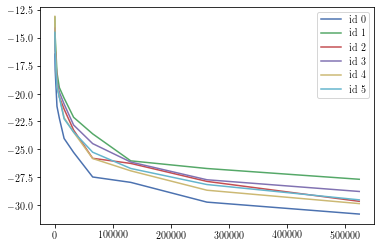

In [21]:
y = list(map(list, zip(*res_list_length)))

for i in range(6):
    plt.plot(x_length,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [22]:
res_list_sigs = []
x_sigs = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]

for i in tqdm.tqdm(x_sigs):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=10.0,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=i,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=20)
    res_list_sigs.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       0
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 10%|█         | 1/10 [01:02<09:26, 62.89s/it]

---- Simulation stats ----
Err time:             -22.4404 dB
Err band:             -19.4373 dB
Err eigenval average: -22.4224 dB
Err eigenval hist:    -20.3203 dB
Err eigenval kde:     -22.0948 dB
Err eigenval mle:     -21.6386 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       0
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 2/10 [02:02<08:14, 61.87s/it]

---- Simulation stats ----
Err time:             -22.3571 dB
Err band:             -19.2855 dB
Err eigenval average: -20.9747 dB
Err eigenval hist:    -21.0818 dB
Err eigenval kde:     -21.2051 dB
Err eigenval mle:     -21.4921 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 30%|███       | 3/10 [02:56<06:57, 59.67s/it]

---- Simulation stats ----
Err time:             -22.2958 dB
Err band:             -18.7954 dB
Err eigenval average: -20.9150 dB
Err eigenval hist:    -19.6586 dB
Err eigenval kde:     -20.9543 dB
Err eigenval mle:     -20.3397 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 4/10 [03:48<05:42, 57.11s/it]

---- Simulation stats ----
Err time:             -22.0584 dB
Err band:             -19.2723 dB
Err eigenval average: -19.8351 dB
Err eigenval hist:    -19.6295 dB
Err eigenval kde:     -20.1241 dB
Err eigenval mle:     -20.2836 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 50%|█████     | 5/10 [04:36<04:33, 54.66s/it]

---- Simulation stats ----
Err time:             -21.9991 dB
Err band:             -19.0891 dB
Err eigenval average: -19.4631 dB
Err eigenval hist:    -18.4188 dB
Err eigenval kde:     -19.0671 dB
Err eigenval mle:     -19.7120 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 6/10 [05:22<03:27, 51.77s/it]

---- Simulation stats ----
Err time:             -21.9526 dB
Err band:             -8.7055 dB
Err eigenval average: -18.7809 dB
Err eigenval hist:    -17.1491 dB
Err eigenval kde:     -18.4320 dB
Err eigenval mle:     -18.8305 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       3
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 70%|███████   | 7/10 [06:02<02:25, 48.42s/it]

---- Simulation stats ----
Err time:             -22.2493 dB
Err band:             -4.6627 dB
Err eigenval average: -18.6141 dB
Err eigenval hist:    -16.0017 dB
Err eigenval kde:     -17.5110 dB
Err eigenval mle:     -17.4541 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       3
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 8/10 [06:42<01:31, 45.90s/it]

---- Simulation stats ----
Err time:             -21.9116 dB
Err band:             -4.8293 dB
Err eigenval average: -17.0623 dB
Err eigenval hist:    -15.2428 dB
Err eigenval kde:     -16.3999 dB
Err eigenval mle:     -16.2456 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       4
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 90%|█████████ | 9/10 [07:24<00:44, 44.74s/it]

---- Simulation stats ----
Err time:             -22.5253 dB
Err band:             -4.4283 dB
Err eigenval average: -11.5425 dB
Err eigenval hist:    -13.2679 dB
Err eigenval kde:     -10.2436 dB
Err eigenval mle:     -14.4215 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       4
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 10/10 [08:10<00:00, 49.00s/it]

---- Simulation stats ----
Err time:             -22.4004 dB
Err band:             -3.4373 dB
Err eigenval average: -3.6644 dB
Err eigenval hist:    -3.5822 dB
Err eigenval kde:     -3.3952 dB
Err eigenval mle:     -4.6507 dB


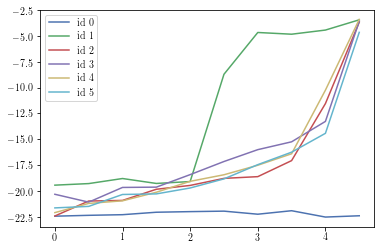

In [23]:
y = list(map(list, zip(*res_list_sigs)))

for i in range(6):
    plt.plot(x_sigs,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [24]:
res_list_snr = []
x_snr = range(-30, 20, 5)

for i in tqdm.tqdm(x_snr):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=i,  # in dB
        noise_power=0.0,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=1,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=20)
    res_list_snr.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   -30.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -30.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 10%|█         | 1/10 [01:03<09:35, 63.96s/it]

---- Simulation stats ----
Err time:             -21.9913 dB
Err band:             -19.1365 dB
Err eigenval average: -20.9239 dB
Err eigenval hist:    -20.3009 dB
Err eigenval kde:     -20.8250 dB
Err eigenval mle:     -21.4609 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   -25.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -25.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 2/10 [02:07<08:31, 63.89s/it]

---- Simulation stats ----
Err time:             -22.4685 dB
Err band:             -19.6150 dB
Err eigenval average: -19.4024 dB
Err eigenval hist:    -19.6376 dB
Err eigenval kde:     -20.2132 dB
Err eigenval mle:     -21.0381 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   -20.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -20.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 30%|███       | 3/10 [03:07<07:19, 62.81s/it]

---- Simulation stats ----
Err time:             -22.9386 dB
Err band:             -19.2078 dB
Err eigenval average: -19.7685 dB
Err eigenval hist:    -20.0204 dB
Err eigenval kde:     -20.7307 dB
Err eigenval mle:     -20.8231 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   -15.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -15.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 4/10 [04:04<06:05, 60.96s/it]

---- Simulation stats ----
Err time:             -23.0002 dB
Err band:             -19.3889 dB
Err eigenval average: -20.1841 dB
Err eigenval hist:    -19.8786 dB
Err eigenval kde:     -20.7828 dB
Err eigenval mle:     -20.4899 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   -10.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -10.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 50%|█████     | 5/10 [04:59<04:55, 59.10s/it]

---- Simulation stats ----
Err time:             -22.3590 dB
Err band:             -19.9718 dB
Err eigenval average: -21.3055 dB
Err eigenval hist:    -19.5969 dB
Err eigenval kde:     -21.0438 dB
Err eigenval mle:     -20.9155 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   -5.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -5.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 6/10 [05:53<03:50, 57.64s/it]

---- Simulation stats ----
Err time:             -22.5757 dB
Err band:             -19.3201 dB
Err eigenval average: -20.2300 dB
Err eigenval hist:    -19.4789 dB
Err eigenval kde:     -20.6292 dB
Err eigenval mle:     -20.1658 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   0.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            0.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 70%|███████   | 7/10 [06:47<02:49, 56.37s/it]

---- Simulation stats ----
Err time:             -22.5573 dB
Err band:             -19.3411 dB
Err eigenval average: -20.8170 dB
Err eigenval hist:    -20.1747 dB
Err eigenval kde:     -21.1273 dB
Err eigenval mle:     -20.8434 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   5.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            5.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 8/10 [07:38<01:49, 54.83s/it]

---- Simulation stats ----
Err time:             -22.4847 dB
Err band:             -18.2555 dB
Err eigenval average: -21.5159 dB
Err eigenval hist:    -20.4832 dB
Err eigenval kde:     -21.2716 dB
Err eigenval mle:     -20.9704 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   10.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            10.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 90%|█████████ | 9/10 [08:29<00:53, 53.64s/it]

---- Simulation stats ----
Err time:             -22.8233 dB
Err band:             -18.9125 dB
Err eigenval average: -21.1573 dB
Err eigenval hist:    -19.8591 dB
Err eigenval kde:     -20.7819 dB
Err eigenval mle:     -20.4911 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   15.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            15.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 10/10 [09:19<00:00, 55.92s/it]

---- Simulation stats ----
Err time:             -22.0423 dB
Err band:             -15.8674 dB
Err eigenval average: -20.8169 dB
Err eigenval hist:    -19.4675 dB
Err eigenval kde:     -20.4727 dB
Err eigenval mle:     -20.2684 dB


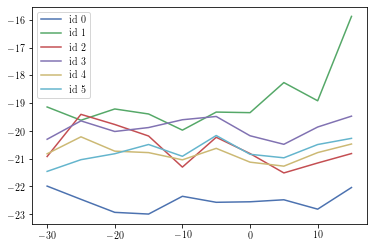

In [25]:
y = list(map(list, zip(*res_list_snr)))

for i in range(6):
    plt.plot(x_snr,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [26]:
res_list_cov1 = []
x_cov1 = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for i in tqdm.tqdm(x_cov1):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=10.0,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=1,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=i)
    res_list_cov1.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 10%|█         | 1/10 [00:31<04:44, 31.63s/it]

---- Simulation stats ----
Err time:             -22.2720 dB
Err band:             -19.3433 dB
Err eigenval average: -19.7826 dB
Err eigenval hist:    -19.7934 dB
Err eigenval kde:     -19.8161 dB
Err eigenval mle:     -20.8840 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 2/10 [01:09<04:28, 33.52s/it]

---- Simulation stats ----
Err time:             -22.6317 dB
Err band:             -19.6194 dB
Err eigenval average: -20.4237 dB
Err eigenval hist:    -20.0959 dB
Err eigenval kde:     -20.6258 dB
Err eigenval mle:     -20.6814 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 30%|███       | 3/10 [01:56<04:23, 37.65s/it]

---- Simulation stats ----
Err time:             -22.0686 dB
Err band:             -19.4901 dB
Err eigenval average: -20.0382 dB
Err eigenval hist:    -19.6522 dB
Err eigenval kde:     -20.5519 dB
Err eigenval mle:     -20.5138 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 4/10 [02:50<04:14, 42.39s/it]

---- Simulation stats ----
Err time:             -22.2297 dB
Err band:             -19.9606 dB
Err eigenval average: -20.9610 dB
Err eigenval hist:    -19.8231 dB
Err eigenval kde:     -20.8549 dB
Err eigenval mle:     -20.8611 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 50%|█████     | 5/10 [03:52<04:01, 48.37s/it]

---- Simulation stats ----
Err time:             -22.2729 dB
Err band:             -19.1219 dB
Err eigenval average: -20.2488 dB
Err eigenval hist:    -19.3898 dB
Err eigenval kde:     -20.5401 dB
Err eigenval mle:     -20.4457 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 6/10 [05:03<03:40, 55.06s/it]

---- Simulation stats ----
Err time:             -22.2323 dB
Err band:             -19.2066 dB
Err eigenval average: -19.9732 dB
Err eigenval hist:    -19.5712 dB
Err eigenval kde:     -20.4012 dB
Err eigenval mle:     -20.2720 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 70%|███████   | 7/10 [06:20<03:04, 61.60s/it]

---- Simulation stats ----
Err time:             -22.3048 dB
Err band:             -19.2310 dB
Err eigenval average: -20.1275 dB
Err eigenval hist:    -20.3205 dB
Err eigenval kde:     -21.0962 dB
Err eigenval mle:     -20.7460 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 8/10 [07:45<02:17, 68.67s/it]

---- Simulation stats ----
Err time:             -22.3877 dB
Err band:             -19.2230 dB
Err eigenval average: -20.0639 dB
Err eigenval hist:    -19.8944 dB
Err eigenval kde:     -20.2597 dB
Err eigenval mle:     -20.7735 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 90%|█████████ | 9/10 [09:20<01:16, 76.54s/it]

---- Simulation stats ----
Err time:             -22.1894 dB
Err band:             -19.5657 dB
Err eigenval average: -20.6060 dB
Err eigenval hist:    -20.4429 dB
Err eigenval kde:     -20.7286 dB
Err eigenval mle:     -20.8354 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 10/10 [11:04<00:00, 66.45s/it]

---- Simulation stats ----
Err time:             -22.1838 dB
Err band:             -18.7286 dB
Err eigenval average: -20.0531 dB
Err eigenval hist:    -19.5489 dB
Err eigenval kde:     -20.2909 dB
Err eigenval mle:     -19.9530 dB


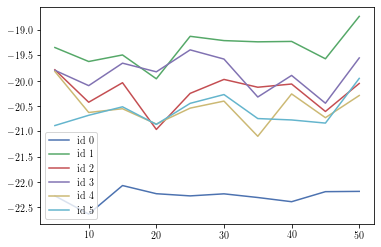

In [27]:
y = list(map(list, zip(*res_list_cov1)))

for i in range(6):
    plt.plot(x_cov1,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [28]:
res_list_cov2 = []
x_cov2 = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for i in tqdm.tqdm(x_cov2):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=10.0,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=2.5,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=i)
    res_list_cov2.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 10%|█         | 1/10 [00:29<04:28, 29.83s/it]

---- Simulation stats ----
Err time:             -22.0813 dB
Err band:             -6.5427 dB
Err eigenval average: -7.2326 dB
Err eigenval hist:    -8.4163 dB
Err eigenval kde:     -5.8224 dB
Err eigenval mle:     -13.8063 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 2/10 [01:03<04:07, 30.99s/it]

---- Simulation stats ----
Err time:             -22.6905 dB
Err band:             -7.9939 dB
Err eigenval average: -19.0670 dB
Err eigenval hist:    -17.9893 dB
Err eigenval kde:     -18.7443 dB
Err eigenval mle:     -18.9373 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 30%|███       | 3/10 [01:42<03:53, 33.32s/it]

---- Simulation stats ----
Err time:             -22.4475 dB
Err band:             -7.6563 dB
Err eigenval average: -18.9515 dB
Err eigenval hist:    -17.2583 dB
Err eigenval kde:     -18.5801 dB
Err eigenval mle:     -18.8701 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 4/10 [02:29<03:44, 37.38s/it]

---- Simulation stats ----
Err time:             -22.0683 dB
Err band:             -9.5149 dB
Err eigenval average: -17.8491 dB
Err eigenval hist:    -15.8243 dB
Err eigenval kde:     -17.3009 dB
Err eigenval mle:     -18.0798 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 50%|█████     | 5/10 [03:50<04:12, 50.42s/it]

---- Simulation stats ----
Err time:             -21.9685 dB
Err band:             -8.0696 dB
Err eigenval average: -18.3921 dB
Err eigenval hist:    -16.6181 dB
Err eigenval kde:     -17.8315 dB
Err eigenval mle:     -18.3808 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 6/10 [04:44<03:26, 51.65s/it]

---- Simulation stats ----
Err time:             -22.5500 dB
Err band:             -6.2761 dB
Err eigenval average: -19.2040 dB
Err eigenval hist:    -16.8124 dB
Err eigenval kde:     -18.3562 dB
Err eigenval mle:     -18.1341 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 70%|███████   | 7/10 [05:55<02:52, 57.58s/it]

---- Simulation stats ----
Err time:             -22.6286 dB
Err band:             -10.3283 dB
Err eigenval average: -15.8194 dB
Err eigenval hist:    -16.4235 dB
Err eigenval kde:     -15.5289 dB
Err eigenval mle:     -17.5457 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 8/10 [07:09<02:04, 62.47s/it]

---- Simulation stats ----
Err time:             -21.8283 dB
Err band:             -9.4945 dB
Err eigenval average: -17.5213 dB
Err eigenval hist:    -16.5782 dB
Err eigenval kde:     -17.0747 dB
Err eigenval mle:     -18.0582 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 90%|█████████ | 9/10 [08:28<01:07, 67.45s/it]

---- Simulation stats ----
Err time:             -21.8953 dB
Err band:             -9.0085 dB
Err eigenval average: -17.9109 dB
Err eigenval hist:    -18.0762 dB
Err eigenval kde:     -17.9329 dB
Err eigenval mle:     -18.8392 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 10/10 [09:49<00:00, 58.95s/it]

---- Simulation stats ----
Err time:             -22.6157 dB
Err band:             -7.4535 dB
Err eigenval average: -18.2952 dB
Err eigenval hist:    -18.2912 dB
Err eigenval kde:     -17.9534 dB
Err eigenval mle:     -18.9708 dB


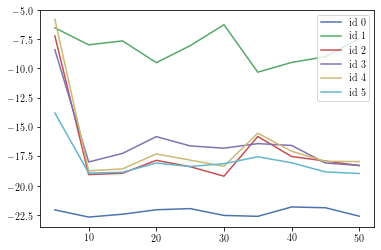

In [29]:
y = list(map(list, zip(*res_list_cov2)))

for i in range(6):
    plt.plot(x_cov2,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [33]:
res_list_cov3 = []
x_cov3 = [20, 40, 60, 80, 100]

for i in tqdm.tqdm(x_cov3):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=10.0,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=4,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=i)
    res_list_cov3.append(res)

  0%|          | 0/5 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       4
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 1/5 [00:43<02:55, 43.83s/it]

---- Simulation stats ----
Err time:             -22.2858 dB
Err band:             -3.9120 dB
Err eigenval average: -12.0396 dB
Err eigenval hist:    -14.1065 dB
Err eigenval kde:     -10.6424 dB
Err eigenval mle:     -15.3118 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       4
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 2/5 [01:44<02:26, 48.73s/it]

---- Simulation stats ----
Err time:             -22.1238 dB
Err band:             -3.2017 dB
Err eigenval average: -15.0278 dB
Err eigenval hist:    -14.4315 dB
Err eigenval kde:     -14.6927 dB
Err eigenval mle:     -14.3611 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       4
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 3/5 [03:09<01:59, 59.66s/it]

---- Simulation stats ----
Err time:             -22.6370 dB
Err band:             -3.9470 dB
Err eigenval average: -13.4443 dB
Err eigenval hist:    -13.2673 dB
Err eigenval kde:     -13.3698 dB
Err eigenval mle:     -13.8137 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       4
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 4/5 [05:16<01:19, 79.87s/it]

---- Simulation stats ----
Err time:             -22.3988 dB
Err band:             -4.2460 dB
Err eigenval average: -12.8434 dB
Err eigenval hist:    -12.2323 dB
Err eigenval kde:     -12.0289 dB
Err eigenval mle:     -13.4096 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       4
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 5/5 [09:29<00:00, 113.89s/it]

---- Simulation stats ----
Err time:             -22.3371 dB
Err band:             -3.4560 dB
Err eigenval average: -13.3467 dB
Err eigenval hist:    -13.3673 dB
Err eigenval kde:     -12.9420 dB
Err eigenval mle:     -14.3222 dB


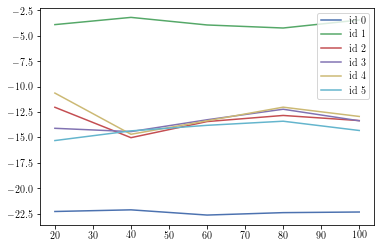

In [34]:
y = list(map(list, zip(*res_list_cov3)))

for i in range(6):
    plt.plot(x_cov3,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

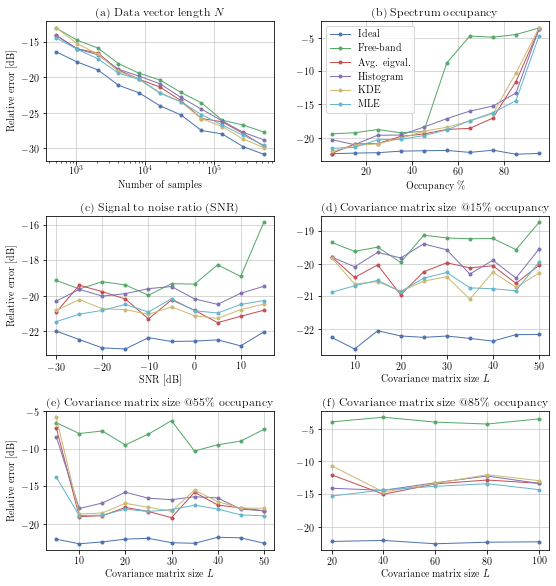

In [36]:
types = [r'Ideal', r'Free-band', r'Avg. eigval.', r'Histogram', r'KDE', r'MLE']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 8.25))

y = list(map(list, zip(*res_list_length)))
for i in range(6):
    axs[0, 0].plot(x_length, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[0, 0].set_xlabel(r'Number of samples')
axs[0, 0].set_ylabel(r'Relative error [dB]')
axs[0, 0].set_title(r'(a) Data vector length $N$')
axs[0, 0].set_xscale('log')
axs[0, 0].grid(linewidth=0.5)

x_special = list(map(lambda x: round((x/5+0.05)*100, 2), x_sigs))
y = list(map(list, zip(*res_list_sigs)))
for i in range(6):
    axs[0, 1].plot(x_special, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[0, 1].set_xlabel(r'Occupancy \%')
# axs[0, 1].set_ylabel(r'Relative error [dB]')
axs[0, 1].set_title(r'(b) Spectrum occupancy')
axs[0, 1].legend(loc=0)
axs[0, 1].grid(linewidth=0.5)

y = list(map(list, zip(*res_list_snr)))
for i in range(6):
    axs[1, 0].plot(x_snr, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[1, 0].set_xlabel(r'SNR [dB]')
axs[1, 0].set_ylabel(r'Relative error [dB]')
axs[1, 0].set_title(r'(c) Signal to noise ratio (SNR)')
axs[1, 0].grid(linewidth=0.5)

y = list(map(list, zip(*res_list_cov1)))
for i in range(6):
    axs[1, 1].plot(x_cov1, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[1, 1].set_xlabel(r'Covariance matrix size $L$')
# axs[1, 1].set_ylabel(r'Relative error [dB]')
axs[1, 1].set_title(r'(d) Covariance matrix size $@15\%$ occupancy')
axs[1, 1].grid(linewidth=0.5)

y = list(map(list, zip(*res_list_cov2)))
for i in range(6):
    axs[2, 0].plot(x_cov2, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[2, 0].set_xlabel(r'Covariance matrix size $L$')
axs[2, 0].set_ylabel(r'Relative error [dB]')
axs[2, 0].set_title(r'(e) Covariance matrix size $@55\%$ occupancy')
axs[2, 0].grid(linewidth=0.5)

y = list(map(list, zip(*res_list_cov3)))
for i in range(6):
    axs[2, 1].plot(x_cov3, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[2, 1].set_xlabel(r'Covariance matrix size $L$')
# axs[2, 1].set_ylabel(r'Relative error [dB]')
axs[2, 1].set_title(r'(f) Covariance matrix size $@85\%$ occupancy')
axs[2, 1].grid(linewidth=0.5)

plt.tight_layout()
plt.savefig('out/chap5/noise_estimation_comparison.pdf')